# Stock Relative Strength (RS) Analysis

This notebook calculates and analyzes Relative Strength (RS) rankings for individual stocks using weekly chart data.

## Methodology

- **Data Source**: `weekly_charts` table from DuckDB
- **Benchmark**: Market-specific indices
  - KOSPI stocks → KOSPI index (001)
  - KOSDAQ stocks → KOSDAQ index (101)
- **RS Formula**: `RS = (Stock % change) / (Market % change)`
- **Periods**:
  - 1 month (4 weeks)
  - 3 months (12 weeks)
  - 6 months (26 weeks)

## Interpretation

- **RS > 1.0**: Stock outperforming market
- **RS = 1.0**: Stock matching market performance
- **RS < 1.0**: Stock underperforming market

In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
import warnings

# Suppress font warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

# Configure matplotlib for Korean font support
def setup_korean_font():
    """Setup matplotlib to display Korean characters properly"""
    korean_fonts = [
        'AppleGothic',       # macOS
        'Malgun Gothic',     # Windows
        'NanumGothic',       # Cross-platform
        'Nanum Gothic',
        'NanumBarunGothic',
        'UnDotum',           # Linux
    ]
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in korean_fonts:
        if font in available_fonts:
            plt.rc('font', family=font)
            plt.rc('axes', unicode_minus=False)
            print(f"✓ Korean font set to: {font}")
            return True
    
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    print("⚠ No Korean font found, using fallback.")
    return False

def get_korean_font():
    """Get Korean font properties for explicit text rendering"""
    korean_fonts = [
        'AppleGothic', 'Malgun Gothic', 'NanumGothic',
        'Nanum Gothic', 'NanumBarunGothic', 'UnDotum'
    ]
    
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    for font in korean_fonts:
        if font in available_fonts:
            return FontProperties(family=font)
    return FontProperties(family='sans-serif')

setup_korean_font()

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Libraries imported successfully")

✓ Korean font set to: AppleGothic
Libraries imported successfully


In [2]:
# Connect to DuckDB
db_path = Path.cwd() / "../data/data.duckdb"
conn = duckdb.connect(str(db_path), read_only=True)

print(f"Connected to DuckDB at: {db_path}")
print(f"Database exists: {db_path.exists()}")

Connected to DuckDB at: /Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/notebooks/../data/data.duckdb
Database exists: True


In [3]:
# Database statistics
stats_query = """
SELECT 
    'Stock Metadata' as table_name,
    COUNT(*) as record_count
FROM stock_metadata
UNION ALL
SELECT 
    'Weekly Charts' as table_name,
    COUNT(*) as record_count
FROM weekly_charts
UNION ALL
SELECT 
    'Weekly Charts - Unique Stocks' as table_name,
    COUNT(DISTINCT stock_code) as record_count
FROM weekly_charts
"""

stats_df = conn.execute(stats_query).df()
print("\n📊 Database Statistics:\n")
display(stats_df)


📊 Database Statistics:



,table_name,record_count
0,Stock Metadata,2606
1,Weekly Charts,382334
2,Weekly Charts - Unique Stocks,2605


In [4]:
# Load stock metadata
metadata_query = """
SELECT 
    stock_code,
    stock_name,
    market_name,
    industry_name,
    market_cap
FROM stock_metadata
WHERE market_name IN ('거래소', '코스닥')
ORDER BY stock_code
"""

stock_metadata = conn.execute(metadata_query).df()

print(f"Total stocks: {len(stock_metadata):,}")
print(f"\nMarket breakdown:")
print(stock_metadata['market_name'].value_counts())
print(f"\nTop industries:")
print(stock_metadata['industry_name'].value_counts().head(10))
print("\nSample data:")
display(stock_metadata.head(10))

Total stocks: 2,606

Market breakdown:
market_name
코스닥    1788
거래소     818
Name: count, dtype: int64

Top industries:
industry_name
전기/전자      380
IT 서비스     250
화학         227
기계/장비      214
제약         180
금융         171
일반서비스      170
유통         166
운송장비/부품    137
금속         135
Name: count, dtype: int64

Sample data:


,stock_code,stock_name,market_name,industry_name,market_cap
0,000020,동화약품,거래소,제약,1749
1,000040,KR모터스,거래소,운송장비/부품,428
2,000050,경방,거래소,유통,1829
3,000070,삼양홀딩스,거래소,금융,8983
4,000080,하이트진로,거래소,음식료/담배,13206
5,000100,유한양행,거래소,제약,94363
6,000120,CJ대한통운,거래소,운송/창고,18797
7,000140,하이트진로홀딩스,거래소,금융,2251
8,000150,두산,거래소,금융,156811
9,000180,성창기업지주,거래소,일반서비스,1071


In [5]:
# Check date range for weekly charts
date_range_query = """
SELECT 
    MIN(date) as start_date,
    MAX(date) as end_date,
    COUNT(DISTINCT date) as total_weeks,
    COUNT(DISTINCT stock_code) as total_stocks
FROM weekly_charts
"""

date_info = conn.execute(date_range_query).df()
print("\n📅 Weekly Charts Date Range:\n")
display(date_info)

# Check market indices availability
index_query = """
SELECT 
    industry_code,
    COUNT(*) as weeks,
    MIN(date) as start_date,
    MAX(date) as end_date
FROM industry_weekly_charts
WHERE industry_code IN ('001', '101')
GROUP BY industry_code
ORDER BY industry_code
"""

index_info = conn.execute(index_query).df()
print("\n📈 Market Indices (001=KOSPI, 101=KOSDAQ):")
display(index_info)


📅 Weekly Charts Date Range:



,start_date,end_date,total_weeks,total_stocks
0,2022-10-27,2025-10-27,381,2605



📈 Market Indices (001=KOSPI, 101=KOSDAQ):


,industry_code,weeks,start_date,end_date
0,001,156,2022-11-07,2025-10-27
1,101,156,2022-11-07,2025-10-27


## RS Calculation Using DuckDB SQL

Calculate Relative Strength for all stocks across multiple periods using SQL window functions for efficiency.

In [6]:
# Calculate RS using DuckDB SQL
rs_query = """
WITH stock_weekly AS (
    SELECT 
        stock_code,
        date,
        close,
        -- Calculate lagged prices for different periods
        LAG(close, 4) OVER (PARTITION BY stock_code ORDER BY date) AS close_4w_ago,
        LAG(close, 12) OVER (PARTITION BY stock_code ORDER BY date) AS close_12w_ago,
        LAG(close, 26) OVER (PARTITION BY stock_code ORDER BY date) AS close_26w_ago
    FROM weekly_charts
),
stock_returns AS (
    SELECT 
        stock_code,
        date,
        close,
        -- Calculate percent changes
        CASE WHEN close_4w_ago > 0 THEN (close - close_4w_ago) / close_4w_ago ELSE NULL END AS ret_1m,
        CASE WHEN close_12w_ago > 0 THEN (close - close_12w_ago) / close_12w_ago ELSE NULL END AS ret_3m,
        CASE WHEN close_26w_ago > 0 THEN (close - close_26w_ago) / close_26w_ago ELSE NULL END AS ret_6m
    FROM stock_weekly
),
market_indices AS (
    SELECT 
        industry_code,
        date,
        close,
        LAG(close, 4) OVER (PARTITION BY industry_code ORDER BY date) AS close_4w_ago,
        LAG(close, 12) OVER (PARTITION BY industry_code ORDER BY date) AS close_12w_ago,
        LAG(close, 26) OVER (PARTITION BY industry_code ORDER BY date) AS close_26w_ago
    FROM industry_weekly_charts
    WHERE industry_code IN ('001', '101')
),
market_returns AS (
    SELECT 
        industry_code,
        date,
        CASE WHEN close_4w_ago > 0 THEN (close - close_4w_ago) / close_4w_ago ELSE NULL END AS mkt_ret_1m,
        CASE WHEN close_12w_ago > 0 THEN (close - close_12w_ago) / close_12w_ago ELSE NULL END AS mkt_ret_3m,
        CASE WHEN close_26w_ago > 0 THEN (close - close_26w_ago) / close_26w_ago ELSE NULL END AS mkt_ret_6m
    FROM market_indices
)
SELECT 
    sr.stock_code,
    sm.stock_name,
    sm.market_name,
    sm.industry_name,
    sm.market_cap,
    sr.date,
    sr.close,
    sr.ret_1m AS stock_ret_1m,
    sr.ret_3m AS stock_ret_3m,
    sr.ret_6m AS stock_ret_6m,
    mr.mkt_ret_1m,
    mr.mkt_ret_3m,
    mr.mkt_ret_6m,
    -- Calculate RS for each period
    CASE WHEN mr.mkt_ret_1m IS NOT NULL AND mr.mkt_ret_1m != 0 
         THEN sr.ret_1m / mr.mkt_ret_1m ELSE NULL END AS rs_1m,
    CASE WHEN mr.mkt_ret_3m IS NOT NULL AND mr.mkt_ret_3m != 0 
         THEN sr.ret_3m / mr.mkt_ret_3m ELSE NULL END AS rs_3m,
    CASE WHEN mr.mkt_ret_6m IS NOT NULL AND mr.mkt_ret_6m != 0 
         THEN sr.ret_6m / mr.mkt_ret_6m ELSE NULL END AS rs_6m
FROM stock_returns sr
JOIN stock_metadata sm ON sr.stock_code = sm.stock_code
JOIN market_returns mr ON sr.date = mr.date
    AND (
        (sm.market_name = '거래소' AND mr.industry_code = '001') OR
        (sm.market_name = '코스닥' AND mr.industry_code = '101')
    )
WHERE sr.date >= '2023-01-01'
ORDER BY sr.stock_code, sr.date
"""

print("Executing RS calculation query (this may take a moment)...")
rs_data = conn.execute(rs_query).df()

# Convert date to datetime
rs_data['date'] = pd.to_datetime(rs_data['date'])

print(f"\n✓ RS calculation complete!")
print(f"Total records: {len(rs_data):,}")
print(f"Unique stocks: {rs_data['stock_code'].nunique():,}")
print(f"Date range: {rs_data['date'].min()} to {rs_data['date'].max()}")
print(f"\nSample RS data:")
display(rs_data[['stock_code', 'stock_name', 'date', 'rs_1m', 'rs_3m', 'rs_6m']].tail(10))

Executing RS calculation query (this may take a moment)...

✓ RS calculation complete!
Total records: 361,575
Unique stocks: 2,605
Date range: 2023-01-02 00:00:00 to 2025-10-27 00:00:00

Sample RS data:


,stock_code,stock_name,date,rs_1m,rs_3m,rs_6m
361565,950220,네오이뮨텍,2025-08-18,4.511,-4.768,-11.482
361566,950220,네오이뮨텍,2025-08-25,-2.895,0.220,0.437
361567,950220,네오이뮨텍,2025-09-01,-109.726,-2.022,-0.472
361568,950220,네오이뮨텍,2025-09-08,-6.598,-1.298,-0.287
361569,950220,네오이뮨텍,2025-09-15,-0.491,-0.424,-0.046
361570,950220,네오이뮨텍,2025-09-22,-5.554,-2.336,-0.660
361571,950220,네오이뮨텍,2025-09-29,-3.089,-3.028,-0.845
361572,950220,네오이뮨텍,2025-10-10,-9.378,-4.650,-0.836
361573,950220,네오이뮨텍,2025-10-13,80.309,-6.944,-2.232
361574,950220,네오이뮨텍,2025-10-20,-3.891,-3.376,-2.107


In [7]:
# Get latest RS values
latest_date = rs_data['date'].max()
latest_rs = rs_data[rs_data['date'] == latest_date].copy()

# Calculate average RS across all periods
latest_rs['rs_avg'] = latest_rs[['rs_1m', 'rs_3m', 'rs_6m']].mean(axis=1)

print(f"Latest RS data as of {latest_date.strftime('%Y-%m-%d')}")
print(f"Stocks with valid RS: {latest_rs['rs_avg'].notna().sum():,}")
print(f"\nRS Summary Statistics:\n")
display(latest_rs[['rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']].describe())

Latest RS data as of 2025-10-27
Stocks with valid RS: 818

RS Summary Statistics:



,rs_1m,rs_3m,rs_6m,rs_avg
count,818.000,817.000,815.000,818.000
mean,0.199,0.101,0.322,0.205
std,0.787,0.734,0.698,0.646
min,-2.062,-2.274,-1.052,-1.796
25%,-0.196,-0.277,-0.055,-0.146
50%,0.000,-0.051,0.133,0.020
75%,0.348,0.257,0.481,0.336
max,7.810,4.469,5.379,4.270


## RS Rankings and Top/Bottom Performers

In [8]:
# Create rankings for each period
def get_top_bottom_performers(df, period_col, n=20):
    """Get top and bottom N performers for a given period"""
    valid_data = df[df[period_col].notna()].copy()
    valid_data = valid_data.sort_values(period_col, ascending=False)
    
    top_n = valid_data.head(n)[['stock_code', 'stock_name', 'market_name', 'industry_name', period_col]].copy()
    top_n['rank'] = range(1, len(top_n) + 1)
    
    bottom_n = valid_data.tail(n)[['stock_code', 'stock_name', 'market_name', 'industry_name', period_col]].copy()
    bottom_n['rank'] = range(len(valid_data) - len(bottom_n) + 1, len(valid_data) + 1)
    bottom_n = bottom_n.sort_values(period_col)
    
    return top_n, bottom_n

# Display rankings for each period
periods = {
    'rs_1m': '1 Month (4 weeks)',
    'rs_3m': '3 Months (12 weeks)',
    'rs_6m': '6 Months (26 weeks)'
}

for period_col, period_name in periods.items():
    print(f"\n{'='*100}")
    print(f"  {period_name.upper()} - TOP & BOTTOM 20 PERFORMERS")
    print(f"{'='*100}\n")
    
    top, bottom = get_top_bottom_performers(latest_rs, period_col, n=20)
    
    print(f"🏆 TOP 20 STRONGEST STOCKS (by {period_name} RS):\n")
    display(top)
    
    print(f"\n⚠️  BOTTOM 20 WEAKEST STOCKS (by {period_name} RS):\n")
    display(bottom)


  1 MONTH (4 WEEKS) - TOP & BOTTOM 20 PERFORMERS

🏆 TOP 20 STRONGEST STOCKS (by 1 Month (4 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_1m,rank
38309,005950,이수화학,거래소,화학,7.810,1
162202,066970,엘앤에프,거래소,전기/전자,6.306,2
1331,000150,두산,거래소,금융,4.124,3
197854,093370,후성,거래소,화학,3.976,4
41118,006400,삼성SDI,거래소,전기/전자,3.833,5
25442,003670,포스코퓨처엠,거래소,전기/전자,3.819,6
36091,005690,파미셀,거래소,제약,3.275,7
192877,090370,메타랩스,거래소,섬유/의류,3.256,8
33282,005070,코스모신소재,거래소,화학,3.199,9
138120,051910,LG화학,거래소,화학,3.196,10



⚠️  BOTTOM 20 WEAKEST STOCKS (by 1 Month (4 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_1m,rank
170095,071950,코아스,거래소,제조,-2.062,818
310842,317450,명인제약,거래소,제약,-1.592,817
348196,450140,코오롱모빌리티그룹,거래소,유통,-1.455,816
8432,001210,금호전기,거래소,전기/전자,-1.331,815
127380,044820,코스맥스비티아이,거래소,금융,-1.134,814
22336,003230,삼양식품,거래소,음식료/담배,-1.116,813
358632,499790,GS피앤엘,거래소,금융,-1.107,812
1923,000230,일동홀딩스,거래소,제약,-1.018,811
24702,003570,SNT다이내믹스,거래소,운송장비/부품,-0.972,810
281984,249420,일동제약,거래소,제약,-0.947,809



  3 MONTHS (12 WEEKS) - TOP & BOTTOM 20 PERFORMERS

🏆 TOP 20 STRONGEST STOCKS (by 3 Months (12 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_3m,rank
348196,450140,코오롱모빌리티그룹,거래소,유통,4.469,1
4733,000660,SK하이닉스,거래소,전기/전자,4.204,2
203005,097230,HJ중공업,거래소,건설,4.159,3
78736,019180,티에이치엔,거래소,전기/전자,3.907,4
253825,195870,해성디에스,거래소,전기/전자,3.752,5
7692,001080,만호제강,거래소,금속,3.679,6
338341,402340,SK스퀘어,거래소,금융,3.484,7
197854,093370,후성,거래소,화학,3.455,8
162202,066970,엘앤에프,거래소,전기/전자,3.378,9
38309,005950,이수화학,거래소,화학,3.206,10



⚠️  BOTTOM 20 WEAKEST STOCKS (by 3 Months (12 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_3m,rank
170095,071950,코아스,거래소,제조,-2.274,817
11244,001530,DI동일,거래소,유통,-2.021,816
197559,093240,형지엘리트,거래소,섬유/의류,-1.803,815
8432,001210,금호전기,거래소,전기/전자,-1.464,814
59443,011230,삼화전자,거래소,전기/전자,-1.457,813
357735,483650,달바글로벌,거래소,화학,-1.353,812
62252,012170,아센디오,거래소,오락/문화,-1.322,811
41266,006490,인스코비,거래소,통신,-1.304,810
66534,013890,지누스,거래소,제조,-1.069,809
112815,037270,YG PLUS,거래소,IT 서비스,-1.042,808



  6 MONTHS (26 WEEKS) - TOP & BOTTOM 20 PERFORMERS

🏆 TOP 20 STRONGEST STOCKS (by 6 Months (26 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_6m,rank
348196,450140,코오롱모빌리티그룹,거래소,유통,5.379,1
302692,298040,효성중공업,거래소,전기/전자,4.867,2
203005,097230,HJ중공업,거래소,건설,4.821,3
103976,034020,두산에너빌리티,거래소,기계/장비,4.102,4
294970,278470,에이피알,거래소,화학,3.534,5
338341,402340,SK스퀘어,거래소,금융,3.328,6
4733,000660,SK하이닉스,거래소,전기/전자,3.308,7
45846,007660,이수페타시스,거래소,전기/전자,3.213,8
1331,000150,두산,거래소,금융,3.211,9
318175,336260,두산퓨얼셀,거래소,전기/전자,3.062,10



⚠️  BOTTOM 20 WEAKEST STOCKS (by 6 Months (26 weeks) RS):



,stock_code,stock_name,market_name,industry_name,rs_6m,rank
170095,071950,코아스,거래소,제조,-1.052,815
17751,002630,오리엔트바이오,거래소,제약,-0.975,814
69929,015020,이스타코,거래소,부동산,-0.950,813
62252,012170,아센디오,거래소,오락/문화,-0.908,812
65352,013360,일성건설,거래소,건설,-0.902,811
11244,001530,DI동일,거래소,유통,-0.895,810
49095,008600,윌비스,거래소,유통,-0.857,809
52201,009410,태영건설,거래소,건설,-0.854,808
15237,002210,동성제약,거래소,제약,-0.843,807
41266,006490,인스코비,거래소,통신,-0.842,806


In [9]:
# Comprehensive ranking table with all periods
ranking_df = latest_rs[['stock_code', 'stock_name', 'market_name', 'industry_name', 
                        'market_cap', 'rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']].copy()
ranking_df = ranking_df.sort_values('rs_avg', ascending=False, na_position='last')
ranking_df['rank'] = range(1, len(ranking_df) + 1)

# Reorder columns
ranking_df = ranking_df[['rank', 'stock_code', 'stock_name', 'market_name', 'industry_name',
                        'market_cap', 'rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']]

print("\n📊 COMPREHENSIVE RS RANKINGS (sorted by average RS)\n")
print("Top 50 Stocks:")
display(ranking_df.head(50))

print("\nBottom 50 Stocks:")
display(ranking_df.tail(50))


📊 COMPREHENSIVE RS RANKINGS (sorted by average RS)

Top 50 Stocks:


,rank,stock_code,stock_name,market_name,industry_name,market_cap,rs_1m,rs_3m,rs_6m,rs_avg
38309,1,005950,이수화학,거래소,화학,2806,7.810,3.206,1.795,4.270
162202,2,066970,엘앤에프,거래소,전기/전자,44342,6.306,3.378,2.058,3.914
4733,3,000660,SK하이닉스,거래소,전기/전자,4069533,2.612,4.204,3.308,3.375
302692,4,298040,효성중공업,거래소,전기/전자,199079,2.643,2.432,4.867,3.314
203005,5,097230,HJ중공업,거래소,건설,25373,0.871,4.159,4.821,3.283
1331,6,000150,두산,거래소,금융,156811,4.124,2.350,3.211,3.229
197854,7,093370,후성,거래소,화학,9546,3.976,3.455,2.066,3.166
103976,8,034020,두산에너빌리티,거래소,기계/장비,568178,3.100,1.616,4.102,2.939
348196,9,450140,코오롱모빌리티그룹,거래소,유통,5016,-1.455,4.469,5.379,2.798
318175,10,336260,두산퓨얼셀,거래소,전기/전자,27966,2.464,2.706,3.062,2.744



Bottom 50 Stocks:


,rank,stock_code,stock_name,market_name,industry_name,market_cap,rs_1m,rs_3m,rs_6m,rs_avg
43630,769,007120,미래아이앤지,거래소,IT 서비스,237,-0.218,-0.584,-0.323,-0.375
113845,770,037560,LG헬로비전,거래소,오락/문화,1890,-0.368,-0.592,-0.165,-0.375
42152,771,006740,블루산업개발,거래소,종이/목재,525,-0.648,-0.362,-0.123,-0.378
58703,772,011090,에넥스,거래소,제조,321,-0.382,-0.405,-0.366,-0.384
23075,773,003350,한국화장품제조,거래소,화학,2447,-0.310,-0.763,-0.081,-0.385
319061,774,339770,교촌에프앤비,거래소,유통,2104,-0.177,-0.637,-0.358,-0.390
21005,775,003060,에이프로젠바이오로직스,거래소,제약,1095,-0.493,-0.373,-0.320,-0.395
60477,776,011420,갤럭시아에스엠,거래소,오락/문화,552,-0.368,-0.626,-0.193,-0.395
22336,777,003230,삼양식품,거래소,음식료/담배,101545,-1.116,-0.519,0.429,-0.402
52793,778,009460,한창제지,거래소,종이/목재,339,-0.409,-0.484,-0.315,-0.403


In [10]:
# Compare KOSPI vs KOSDAQ RS performance
market_comparison = latest_rs.groupby('market_name')[['rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']].agg([
    'mean', 'median', 'std', 'count'
]).round(3)

print("\n📈 KOSPI vs KOSDAQ RS Comparison:\n")
display(market_comparison)


📈 KOSPI vs KOSDAQ RS Comparison:



rs_1m                    rs_3m                    rs_6m         \
             mean median   std count  mean median   std count  mean median   
market_name                                                                  
거래소         0.199  0.000 0.787   818 0.101 -0.051 0.734   817 0.322  0.133   

                        rs_avg                     
              std count   mean median   std count  
market_name                                        
거래소         0.698   815  0.205  0.020 0.646   818

In [11]:
# Top industries by average RS
industry_rs = latest_rs.groupby('industry_name')[['rs_1m', 'rs_3m', 'rs_6m', 'rs_avg']].agg([
    'mean', 'count'
]).round(3)

# Filter industries with at least 5 stocks
industry_rs_filtered = industry_rs[industry_rs[('rs_avg', 'count')] >= 5]
industry_rs_sorted = industry_rs_filtered.sort_values(('rs_avg', 'mean'), ascending=False)

print("\n🏭 TOP 20 INDUSTRIES by Average RS (min 5 stocks):\n")
display(industry_rs_sorted.head(20))

print("\n🏭 BOTTOM 20 INDUSTRIES by Average RS (min 5 stocks):\n")
display(industry_rs_sorted.tail(20))


🏭 TOP 20 INDUSTRIES by Average RS (min 5 stocks):



rs_1m        rs_3m       rs_6m       rs_avg      
                mean count   mean count  mean count   mean count
industry_name                                                   
전기/전자          0.870    68  0.799    68 0.821    68  0.830    68
증권             0.326    18  0.471    18 0.932    18  0.576    18
의료/정밀기기        0.266     8  0.734     8 0.541     8  0.514     8
기계/장비          0.380    32  0.248    32 0.560    32  0.396    32
금융             0.237    72  0.122    72 0.653    72  0.337    72
전기/가스          0.407    10  0.124    10 0.465    10  0.332    10
운송장비/부품        0.303    61  0.237    61 0.309    60  0.278    61
화학             0.405   103  0.123   103 0.283   102  0.266   103
금속             0.234    62  0.105    62 0.266    62  0.202    62
보험            -0.122    12  0.126    12 0.565    12  0.190    12
IT 서비스         0.038    26  0.018    26 0.331    26  0.129    26
일반서비스          0.070    34 -0.012    34 0.290    34  0.116    34
건설             0.145    29 -0.044    29 0.195    29  0.099    29
제약            -0.001    48  0.073    47 0.141    47  0.047    48
유통            -0.015    65 -0.048    65 0.134    65  0.024    65
운송/창고         -0.068    25 -0.195    25 0.148    25 -0.038    25
섬유/의류         -0.081    30 -0.146    30 0.068    30 -0.053    30
비금속            0.013    22 -0.226    22 0.037    22 -0.059    22
              -0.122     7 -0.221     7 0.144     7 -0.066     7
오락/문화          0.026    14 -0.310    14 0.055    14 -0.076    14


🏭 BOTTOM 20 INDUSTRIES by Average RS (min 5 stocks):



rs_1m        rs_3m        rs_6m       rs_avg      
                mean count   mean count   mean count   mean count
industry_name                                                    
금융             0.237    72  0.122    72  0.653    72  0.337    72
전기/가스          0.407    10  0.124    10  0.465    10  0.332    10
운송장비/부품        0.303    61  0.237    61  0.309    60  0.278    61
화학             0.405   103  0.123   103  0.283   102  0.266   103
금속             0.234    62  0.105    62  0.266    62  0.202    62
보험            -0.122    12  0.126    12  0.565    12  0.190    12
IT 서비스         0.038    26  0.018    26  0.331    26  0.129    26
일반서비스          0.070    34 -0.012    34  0.290    34  0.116    34
건설             0.145    29 -0.044    29  0.195    29  0.099    29
제약            -0.001    48  0.073    47  0.141    47  0.047    48
유통            -0.015    65 -0.048    65  0.134    65  0.024    65
운송/창고         -0.068    25 -0.195    25  0.148    25 -0.038    25
섬유/의류         -0.081    30 -0.146    30  0.068    30 -0.053    30
비금속            0.013    22 -0.226    22  0.037    22 -0.059    22
              -0.122     7 -0.221     7  0.144     7 -0.066     7
오락/문화          0.026    14 -0.310    14  0.055    14 -0.076    14
음식료/담배        -0.156    37 -0.195    37  0.053    37 -0.100    37
통신             0.027     5 -0.352     5 -0.067     5 -0.131     5
종이/목재         -0.140    19 -0.229    19 -0.082    19 -0.150    19
제조            -0.528     8 -0.701     8 -0.271     8 -0.500     8

## RS Trend Visualizations

In [12]:
# Display RS trends as table with sparklines
def create_sparkline(data):
    """Create a text-based sparkline from a series of numbers"""
    if len(data) == 0 or data.isna().all():
        return ''
    
    # Remove NaN values
    clean_data = data.dropna()
    if len(clean_data) == 0:
        return ''
    
    # Normalize to 0-7 range for 8 unicode block characters
    min_val = clean_data.min()
    max_val = clean_data.max()
    
    if max_val == min_val:
        return '▄' * len(clean_data)
    
    # Unicode block characters for sparklines
    chars = '▁▂▃▄▅▆▇█'
    
    # Normalize and convert to sparkline
    normalized = ((clean_data - min_val) / (max_val - min_val) * 7).round().astype(int)
    sparkline = ''.join(chars[val] for val in normalized)
    
    return sparkline

def show_rs_trends_table(rs_data, latest_rs, period_col, period_name, n_show=10, weeks_back=30):
    """Show RS trends as a table with sparklines for top and bottom performers"""
    
    print(f"\n{'='*120}")
    print(f"  {period_name.upper()} RS TRENDS - TOP {n_show} & BOTTOM {n_show} PERFORMERS (Last {weeks_back} Weeks)")
    print(f"{'='*120}\n")
    
    # Get top and bottom performers
    valid_latest = latest_rs[latest_rs[period_col].notna()].sort_values(period_col, ascending=False)
    top_codes = valid_latest.head(n_show)['stock_code'].tolist()
    bottom_codes = valid_latest.tail(n_show)['stock_code'].tolist()
    
    # Filter data for last N weeks
    cutoff_date = rs_data['date'].max() - pd.Timedelta(weeks=weeks_back)
    recent_data = rs_data[rs_data['date'] >= cutoff_date].copy()
    
    # Prepare data for top performers
    top_data = []
    for stock_code in top_codes:
        stock_data = recent_data[recent_data['stock_code'] == stock_code].sort_values('date')
        if len(stock_data) > 0:
            stock_name = stock_data['stock_name'].iloc[0]
            industry = stock_data['industry_name'].iloc[0]
            current_rs = stock_data[period_col].iloc[-1] if not stock_data[period_col].isna().all() else None
            sparkline = create_sparkline(stock_data[period_col])
            
            # Calculate statistics
            mean_rs = stock_data[period_col].mean()
            max_rs = stock_data[period_col].max()
            min_rs = stock_data[period_col].min()
            
            top_data.append({
                'Code': stock_code,
                'Name': stock_name[:15],
                'Industry': industry[:12],
                'Current RS': current_rs,
                'Mean': mean_rs,
                'Max': max_rs,
                'Min': min_rs,
                'Trend (30w)': sparkline
            })
    
    # Prepare data for bottom performers
    bottom_data = []
    for stock_code in bottom_codes:
        stock_data = recent_data[recent_data['stock_code'] == stock_code].sort_values('date')
        if len(stock_data) > 0:
            stock_name = stock_data['stock_name'].iloc[0]
            industry = stock_data['industry_name'].iloc[0]
            current_rs = stock_data[period_col].iloc[-1] if not stock_data[period_col].isna().all() else None
            sparkline = create_sparkline(stock_data[period_col])
            
            # Calculate statistics
            mean_rs = stock_data[period_col].mean()
            max_rs = stock_data[period_col].max()
            min_rs = stock_data[period_col].min()
            
            bottom_data.append({
                'Code': stock_code,
                'Name': stock_name[:15],
                'Industry': industry[:12],
                'Current RS': current_rs,
                'Mean': mean_rs,
                'Max': max_rs,
                'Min': min_rs,
                'Trend (30w)': sparkline
            })
    
    # Create DataFrames
    top_df = pd.DataFrame(top_data)
    bottom_df = pd.DataFrame(bottom_data)
    
    # Display tables
    print(f"🏆 TOP {n_show} STRONGEST STOCKS:\n")
    if len(top_df) > 0:
        # Format numeric columns
        display_top = top_df.copy()
        for col in ['Current RS', 'Mean', 'Max', 'Min']:
            display_top[col] = display_top[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
        display(display_top)
    else:
        print("No data available")
    
    print(f"\n⚠️  BOTTOM {n_show} WEAKEST STOCKS:\n")
    if len(bottom_df) > 0:
        # Format numeric columns
        display_bottom = bottom_df.copy()
        for col in ['Current RS', 'Mean', 'Max', 'Min']:
            display_bottom[col] = display_bottom[col].apply(lambda x: f"{x:.3f}" if pd.notna(x) else "N/A")
        display(display_bottom)
    else:
        print("No data available")
    
    print(f"\n{'='*120}\n")
    
    # Add interpretation guide
    print("📊 Sparkline Interpretation:")
    print("  • Each character represents 1 week of RS values")
    print("  • Height shows relative RS strength: ▁ (lowest) to █ (highest)")
    print("  • Upward trend ▁▂▃▄▅▆▇█ = Improving RS")
    print("  • Downward trend █▇▆▅▄▃▂▁ = Declining RS")
    print("  • Flat trend ▄▄▄▄▄▄▄▄ = Stable RS\n")

# Display trends for each period
for period_col, period_name in periods.items():
    show_rs_trends_table(rs_data, latest_rs, period_col, period_name, n_show=10, weeks_back=30)


  1 MONTH (4 WEEKS) RS TRENDS - TOP 10 & BOTTOM 10 PERFORMERS (Last 30 Weeks)

🏆 TOP 10 STRONGEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,005950,이수화학,화학,7.810,2.699,58.516,-5.561,▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▁▃▁█▂▂▂▂▁▂▂▂
1,066970,엘앤에프,전기/전자,6.306,5.456,112.012,-30.363,▃▃▃▂▃▃▂▂▂▂▂▃▂▂▃▃▃▃▄▄▁▂█▂▂▃▃▃▃▃▃
2,000150,두산,금융,4.124,2.834,23.523,-11.586,▄▄▄▁▅▄▅█▅▅▄▄▄▃▃▃▃▄▄▂▄▃▆▄▃▃▃▃▄▄▄
3,093370,후성,화학,3.976,-1.461,18.591,-66.824,▇▇▇▇▆▆▆▆▆▇▇▇▇▇▆▆▆▆▇█▄█▁▆▇▆▇▇▇▇▇
4,006400,삼성SDI,전기/전자,3.833,3.339,55.707,-16.149,▃▃▃▄▂▃▂▂▃▃▃▃▃▃▃▃▃▃▅▄▁▃█▂▃▃▃▃▃▃▃
5,003670,포스코퓨처엠,전기/전자,3.819,3.536,82.055,-12.391,▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▂▂▂▂▂▂▂▂
6,005690,파미셀,제약,3.275,4.938,90.716,-10.226,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▁█▂▂▂▂▂▂▂▂
7,090370,메타랩스,섬유/의류,3.256,1.465,35.444,-3.565,▁▂▂▃▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▁█▂▂▂▂▂▂▂▂
8,005070,코스모신소재,화학,3.199,1.014,30.379,-25.946,▅▅▅▅▄▄▄▂▄▄▄▄▄▄▄▄▅▄▆█▁▅▅▄▄▄▄▄▄▅▅
9,051910,LG화학,화학,3.196,2.233,29.172,-10.428,▃▃▃█▂▃▂▁▃▃▃▃▃▃▃▄▅▄▃▃▄▂▄▃▃▃▃▃▃▃▃



⚠️  BOTTOM 10 WEAKEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,249420,일동제약,제약,-0.947,0.351,17.078,-50.254,▆▆▆▄▆▆▆▆▆▆▆▆▆▆▇███▇▅▅█▁▆▇▆▆▇▆▆▆
1,003570,SNT다이내믹스,운송장비/부품,-0.972,-1.396,10.077,-64.135,█▇▇▄▇▇▇█▇▇█▇▇▇▇▇▇█▇█▅▇▁▇▇▇▇▇▇▇▇
2,000230,일동홀딩스,제약,-1.018,0.271,7.196,-13.740,▆▆▆▄▅▆▅▆▆▆▆▆▆▆▇██▇▄▃▆█▁▆▆▆▆▆▅▅▅
3,499790,GS피앤엘,금융,-1.107,-1.894,22.630,-109.293,▇▇▇▅▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▆█▁▇▇▇▇▇▇▇▇
4,003230,삼양식품,음식료/담배,-1.116,-1.076,12.081,-43.763,▇▇▆▃▇▇▇█▇▇▇▇▇▇▇▇▆▇▆▆▅▇▁▇▇▆▆▆▆▆▆
5,044820,코스맥스비티아이,금융,-1.134,1.855,60.296,-16.992,▂▂▂▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▃▃█▃▃▂▃▂▂▂▂
6,001210,금호전기,전기/전자,-1.331,-3.615,94.261,-191.715,▆▆▅▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆█▆▆▆▆▆▆▆▆
7,450140,코오롱모빌리티그룹,유통,-1.455,7.886,68.816,-61.524,▄▄▅▆▄▄▄▄▄▄▄▄▄▄▄▄▄▄▇▇▁▆▆▅▅█▅▅▄▄▄
8,317450,명인제약,제약,-1.592,-1.592,-1.592,-1.592,▄
9,071950,코아스,제조,-2.062,-2.968,5.400,-33.520,▇▇▇▃▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▁▇▆▆▆▆▆▆▆▇▇




📊 Sparkline Interpretation:
  • Each character represents 1 week of RS values
  • Height shows relative RS strength: ▁ (lowest) to █ (highest)
  • Upward trend ▁▂▃▄▅▆▇█ = Improving RS
  • Downward trend █▇▆▅▄▃▂▁ = Declining RS
  • Flat trend ▄▄▄▄▄▄▄▄ = Stable RS


  3 MONTHS (12 WEEKS) RS TRENDS - TOP 10 & BOTTOM 10 PERFORMERS (Last 30 Weeks)

🏆 TOP 10 STRONGEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,450140,코오롱모빌리티그룹,유통,4.469,7.948,67.602,-23.393,▃▄▄▁▁▆▄▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▅█▅▅▄▃▃
1,000660,SK하이닉스,전기/전자,4.204,2.566,17.818,-6.465,▄▄▆▁▁█▄▃▃▃▃▃▄▃▄▃▃▃▃▃▃▃▃▄▃▄▄▄▄▄▄
2,097230,HJ중공업,건설,4.159,6.204,26.632,-15.992,▅▂▂█▆▁▁▅▃▄▄▄▄▄▄▄▄▄▄▄▅▆██▇█▇▇▆▅▄
3,019180,티에이치엔,전기/전자,3.907,2.772,12.656,-8.057,▅▅▅▁▃█▇▂▃▃▃▄▄▄▄▄▄▄▄▄▅▆▆▆▇▇▆▆▆▅▅
4,195870,해성디에스,전기/전자,3.752,3.232,70.185,-16.289,▃▃▃▂▂█▅▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
5,001080,만호제강,금속,3.679,-0.281,7.985,-37.351,▆▇▆▇█▁▃▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇
6,402340,SK스퀘어,금융,3.484,2.899,11.846,-4.069,▅▄▆▁▂█▂▅▅▅▅▄▅▄▅▄▄▄▃▄▃▃▃▄▄▄▄▅▅▄▄
7,093370,후성,화학,3.455,2.122,27.668,-9.974,▄▄▄▁▂█▆▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
8,066970,엘앤에프,전기/전자,3.378,2.739,43.679,-20.840,▅▄▅▁▂█▇▁▃▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▃▄▄▄
9,005950,이수화학,화학,3.206,1.527,27.609,-9.433,▄▄▄▁▂█▇▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃



⚠️  BOTTOM 10 WEAKEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,037270,YG PLUS,IT 서비스,-1.042,-1.641,27.050,-87.687,▅▆▅██▁▆▆▇▇▇▇▇▇▇▆▆▆▇▆▇▆▇▆▆▆▆▆▆▆▆
1,013890,지누스,제조,-1.069,0.184,18.925,-15.329,█▆▆▁▂▃▆▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
2,006490,인스코비,통신,-1.304,-1.245,23.787,-17.055,▄▄▃▄▁▅█▂▄▄▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▄▄▄
3,012170,아센디오,오락/문화,-1.322,-6.654,86.614,-238.798,▆▆▅██▁▄▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
4,483650,달바글로벌,화학,-1.353,-0.443,2.072,-2.455,▇▇█▄▄▄▃▁▂▂▄▃
5,011230,삼화전자,전기/전자,-1.457,-3.345,38.583,-104.254,▆▆▅█▇▁▄▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
6,001210,금호전기,전기/전자,-1.464,-0.460,35.519,-88.082,▇▆▆██▁▃▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
7,093240,형지엘리트,섬유/의류,-1.803,-1.838,12.724,-22.171,▆▄▃▇█▁▃▅▅▅▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▅▅▅▅
8,001530,DI동일,유통,-2.021,0.395,32.318,-10.242,▃▃▄▁▂█▆▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂
9,071950,코아스,제조,-2.274,-1.155,10.704,-9.515,▃▂▃█▅▁▃▅▅▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▃▃▃▃▃▄▄




📊 Sparkline Interpretation:
  • Each character represents 1 week of RS values
  • Height shows relative RS strength: ▁ (lowest) to █ (highest)
  • Upward trend ▁▂▃▄▅▆▇█ = Improving RS
  • Downward trend █▇▆▅▄▃▂▁ = Declining RS
  • Flat trend ▄▄▄▄▄▄▄▄ = Stable RS


  6 MONTHS (26 WEEKS) RS TRENDS - TOP 10 & BOTTOM 10 PERFORMERS (Last 30 Weeks)

🏆 TOP 10 STRONGEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,450140,코오롱모빌리티그룹,유통,5.379,2.380,23.797,-10.882,▃▃▄▄▂▁▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅█▅▅▅▄▄
1,298040,효성중공업,전기/전자,4.867,5.411,31.268,-12.032,▂▃▂▁█▆▃▅▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
2,097230,HJ중공업,건설,4.821,15.926,366.141,-182.433,▃▃▃▁█▇▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
3,034020,두산에너빌리티,기계/장비,4.102,7.803,56.359,-24.761,▂▃▃▁█▇▄▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▄▃▄▃▃▃
4,278470,에이피알,화학,3.534,15.167,172.766,-28.317,▂▂▂▁▅█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂
5,402340,SK스퀘어,금융,3.328,3.113,12.865,-2.727,▁▂▃▄█▁▄▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄
6,000660,SK하이닉스,전기/전자,3.308,1.704,5.771,-8.241,▅▅▆█▇▁▆▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇
7,007660,이수페타시스,전기/전자,3.213,6.123,44.628,1.166,▁▁▂▃▃█▂▄▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
8,000150,두산,금융,3.211,8.091,108.424,-34.768,▂▂▂▁█▆▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
9,336260,두산퓨얼셀,전기/전자,3.062,1.411,6.124,-18.796,█▇██▁▄▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇



⚠️  BOTTOM 10 WEAKEST STOCKS:



,Code,Name,Industry,Current RS,Mean,Max,Min,Trend (30w)
0,006490,인스코비,통신,-0.842,1.158,27.494,-2.845,▃▃▃▃▂█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
1,002210,동성제약,제약,-0.843,-3.552,15.163,-60.728,▇▇▇█▅▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇
2,009410,태영건설,건설,-0.854,0.400,33.228,-26.564,▅▅▅█▂▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
3,008600,윌비스,유통,-0.857,2.194,98.250,-44.296,▂▂▂▁▇█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
4,001530,DI동일,유통,-0.895,-0.701,14.968,-15.050,▃▄▄▁██▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
5,013360,일성건설,건설,-0.902,5.149,223.855,-126.759,▃▃▃▁▇█▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄
6,012170,아센디오,오락/문화,-0.908,2.508,37.664,-10.471,▃▃▃▁██▃▃▃▃▃▃▂▂▂▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂
7,015020,이스타코,부동산,-0.950,3.714,187.787,-91.407,▂▃▂▁▆█▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
8,002630,오리엔트바이오,제약,-0.975,14.352,437.437,-163.352,▂▂▂▁▆█▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
9,071950,코아스,제조,-1.052,-0.211,3.486,-8.580,█▆▆▆▁▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▅▅▅▅▅▅▅▅




📊 Sparkline Interpretation:
  • Each character represents 1 week of RS values
  • Height shows relative RS strength: ▁ (lowest) to █ (highest)
  • Upward trend ▁▂▃▄▅▆▇█ = Improving RS
  • Downward trend █▇▆▅▄▃▂▁ = Declining RS
  • Flat trend ▄▄▄▄▄▄▄▄ = Stable RS



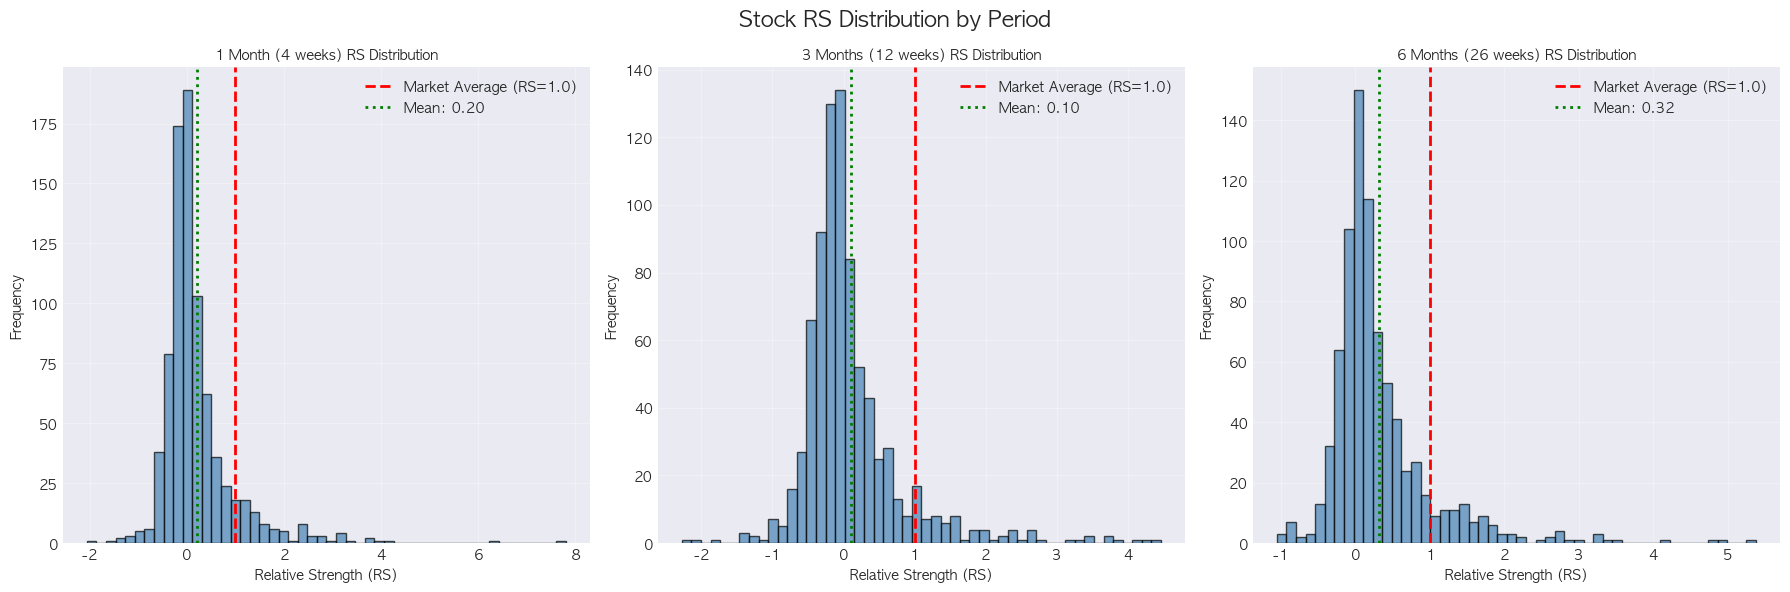

In [13]:
# RS distribution histograms
korean_font = get_korean_font()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Stock RS Distribution by Period', fontsize=16, fontweight='bold', 
             fontproperties=korean_font)

axes = axes.flatten()
period_list = list(periods.items())

for idx, (period_col, period_name) in enumerate(period_list):
    ax = axes[idx]
    
    # Plot histogram
    data = latest_rs[period_col].dropna()
    ax.hist(data, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    
    # Add vertical line at RS = 1.0
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Market Average (RS=1.0)')
    
    # Add statistics
    mean_rs = data.mean()
    median_rs = data.median()
    ax.axvline(x=mean_rs, color='green', linestyle=':', linewidth=2, label=f'Mean: {mean_rs:.2f}')
    
    ax.set_title(f'{period_name} RS Distribution', fontsize=12, fontweight='bold',
                fontproperties=korean_font)
    ax.set_xlabel('Relative Strength (RS)', fontsize=10, fontproperties=korean_font)
    ax.set_ylabel('Frequency', fontsize=10, fontproperties=korean_font)
    ax.legend(prop=korean_font, fontsize=9)
    ax.grid(True, alpha=0.3)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(korean_font)

plt.tight_layout()
plt.show()

## RS Momentum Analysis

Calculate the rate of change of RS over 4 weeks to identify accelerating/decelerating trends.

In [14]:
# Calculate RS momentum (rate of change over 4 weeks)
def calculate_rs_momentum(rs_data, momentum_weeks=4):
    """Calculate RS momentum as percentage change over specified weeks"""
    
    # Sort by stock and date ONCE
    sorted_data = rs_data.sort_values(['stock_code', 'date']).copy()
    
    # Calculate momentum for each period
    for period_col in ['rs_1m', 'rs_3m', 'rs_6m']:
        sorted_data[f'{period_col}_momentum'] = sorted_data.groupby('stock_code')[period_col].pct_change(
            periods=momentum_weeks, fill_method=None
        ) * 100
    
    return sorted_data

print("Calculating RS momentum (4-week rate of change)...")
rs_data_with_momentum = calculate_rs_momentum(rs_data, momentum_weeks=4)

# Get latest momentum values
latest_momentum = rs_data_with_momentum[rs_data_with_momentum['date'] == latest_date].copy()

print("\n✓ RS Momentum calculation complete!")
print("\nMomentum Summary Statistics:\n")
momentum_cols = ['rs_1m_momentum', 'rs_3m_momentum', 'rs_6m_momentum']
display(latest_momentum[momentum_cols].describe())

Calculating RS momentum (4-week rate of change)...

✓ RS Momentum calculation complete!

Momentum Summary Statistics:



/Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Volumes/kgcrom-2tb/kgcrom/workspace/cluefin/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,rs_1m_momentum,rs_3m_momentum,rs_6m_momentum
count,795.000,794.000,797.000
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,-inf,-inf,-inf
25%,-168.626,-102.767,-73.705
50%,-93.261,-78.687,-45.102
75%,-28.142,-57.200,-10.930
max,inf,inf,inf


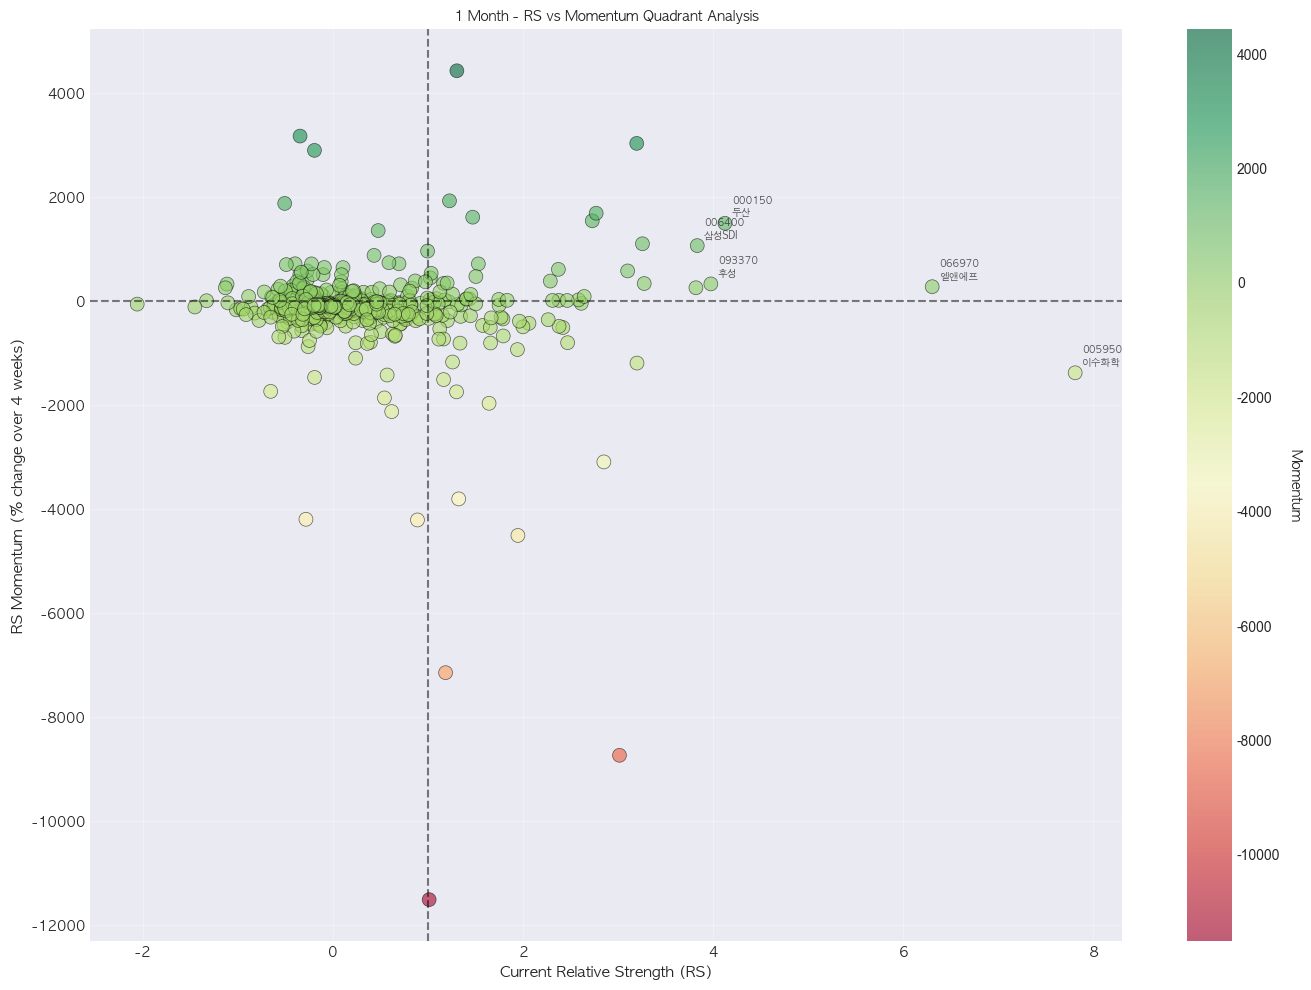

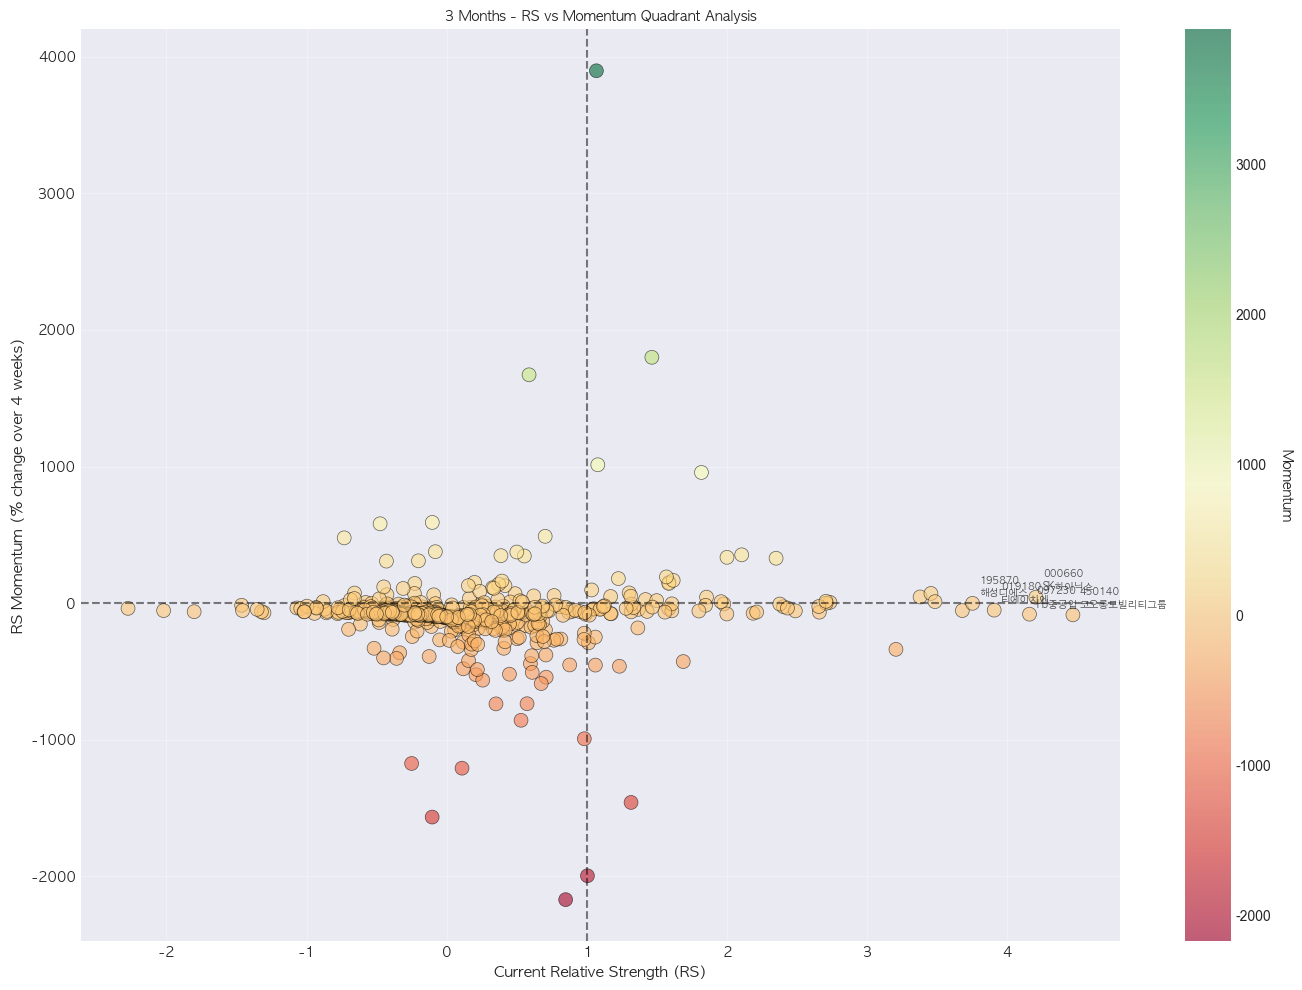

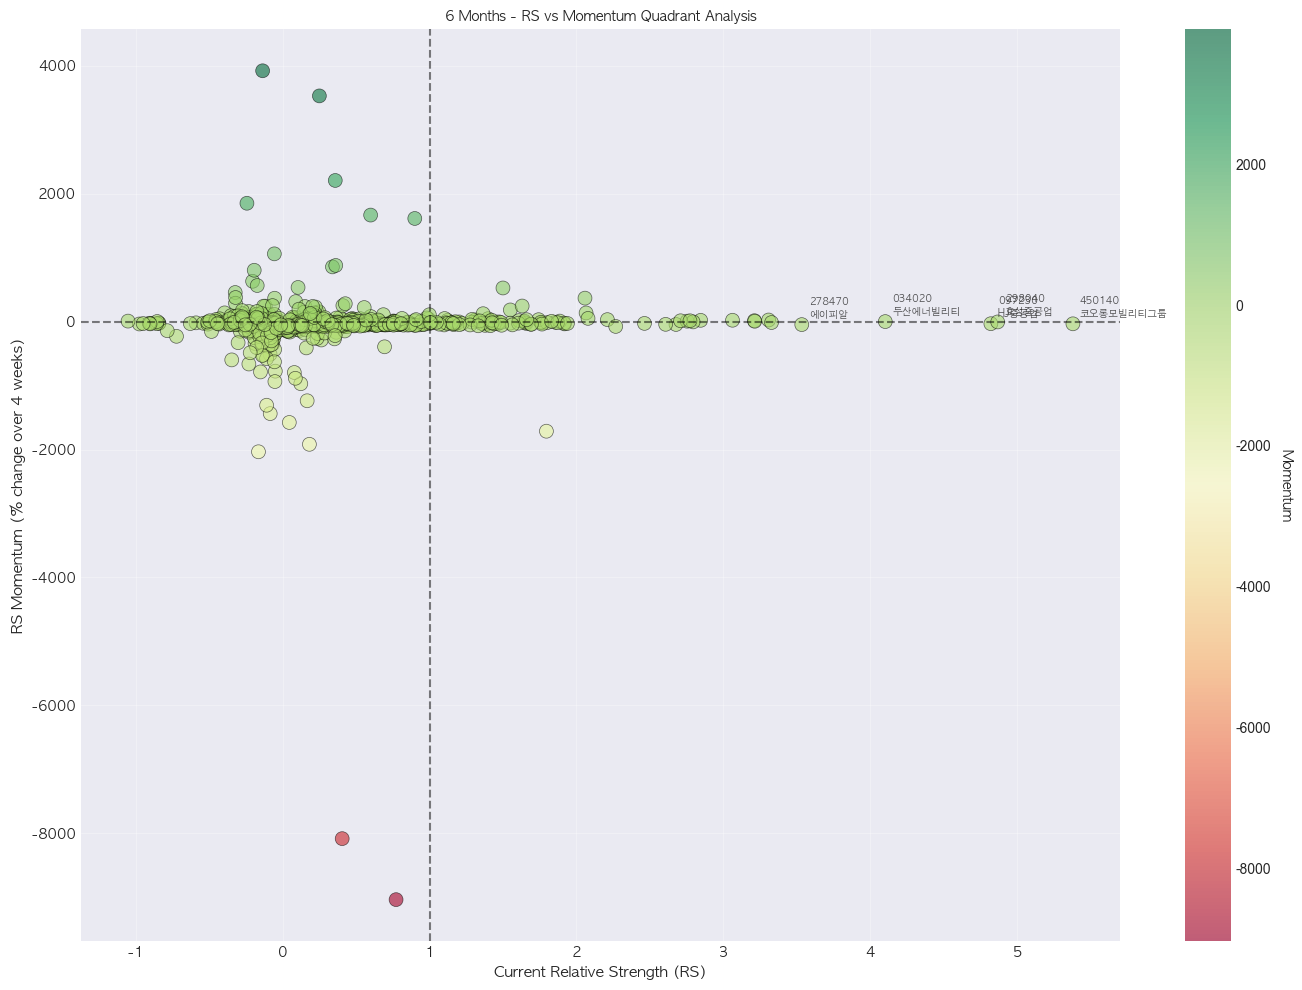

In [15]:
# RS vs Momentum Quadrant Analysis
def plot_rs_momentum_quadrant(latest_data, period_col, momentum_col, period_name):
    """Create scatter plot of RS vs Momentum with quadrant analysis"""
    korean_font = get_korean_font()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Get valid data
    plot_data = latest_data[[period_col, momentum_col, 'stock_code', 'stock_name']].dropna()
    
    # Create scatter plot
    scatter = ax.scatter(plot_data[period_col], plot_data[momentum_col],
                        c=plot_data[momentum_col], cmap='RdYlGn',
                        s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add reference lines
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.axvline(x=1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    
    # Label top performers
    top_rs = plot_data.nlargest(5, period_col)
    for idx, row in top_rs.iterrows():
        ax.annotate(f"{row['stock_code']}\n{row['stock_name']}",
                   xy=(row[period_col], row[momentum_col]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=7, alpha=0.8, fontproperties=korean_font)
    
    # Add quadrant labels
    y_max = plot_data[momentum_col].max()
    y_min = plot_data[momentum_col].min()
    x_max = plot_data[period_col].max()
    x_min = plot_data[period_col].min()
    
    ax.text(x_max*0.95, y_max*0.95, 'Strong + Accelerating\n(BEST)',
           ha='right', va='top', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
           fontproperties=korean_font)
    
    ax.text(x_min*1.05 if x_min > 0 else x_min*0.95, y_max*0.95, 
           'Weak + Accelerating\n(IMPROVING)',
           ha='left', va='top', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
           fontproperties=korean_font)
    
    ax.text(x_max*0.95, y_min*0.95, 'Strong + Decelerating\n(WATCH)',
           ha='right', va='bottom', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
           fontproperties=korean_font)
    
    ax.text(x_min*1.05 if x_min > 0 else x_min*0.95, y_min*0.95, 
           'Weak + Decelerating\n(WORST)',
           ha='left', va='bottom', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7),
           fontproperties=korean_font)
    
    ax.set_title(f'{period_name} - RS vs Momentum Quadrant Analysis',
                fontsize=14, fontweight='bold', fontproperties=korean_font)
    ax.set_xlabel('Current Relative Strength (RS)', fontsize=11, fontproperties=korean_font)
    ax.set_ylabel('RS Momentum (% change over 4 weeks)', fontsize=11, fontproperties=korean_font)
    ax.grid(True, alpha=0.3)
    
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(korean_font)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Momentum', rotation=270, labelpad=15, fontsize=10, fontproperties=korean_font)
    
    plt.tight_layout()
    plt.show()

# Plot quadrant analysis for each period
period_momentum_pairs = [
    ('rs_1m', 'rs_1m_momentum', '1 Month'),
    ('rs_3m', 'rs_3m_momentum', '3 Months'),
    ('rs_6m', 'rs_6m_momentum', '6 Months')
]

for rs_col, mom_col, period_name in period_momentum_pairs:
    plot_rs_momentum_quadrant(latest_momentum, rs_col, mom_col, period_name)

In [16]:
# Identify stocks in each quadrant
def classify_quadrant(rs, momentum, rs_threshold=1.0, momentum_threshold=0):
    """Classify stock into quadrant based on RS and momentum"""
    if pd.isna(rs) or pd.isna(momentum):
        return 'Unknown'
    
    if rs >= rs_threshold and momentum >= momentum_threshold:
        return 'Strong + Accelerating (BEST)'
    elif rs < rs_threshold and momentum >= momentum_threshold:
        return 'Weak + Accelerating (IMPROVING)'
    elif rs >= rs_threshold and momentum < momentum_threshold:
        return 'Strong + Decelerating (WATCH)'
    else:
        return 'Weak + Decelerating (WORST)'

# Classify stocks for 1-month period
latest_momentum['quadrant_1m'] = latest_momentum.apply(
    lambda row: classify_quadrant(row['rs_1m'], row['rs_1m_momentum']),
    axis=1
)

print("\n📊 Stock Distribution by Quadrant (1-Month RS):\n")
quadrant_counts = latest_momentum['quadrant_1m'].value_counts()
print(quadrant_counts)

print("\n🏆 BEST Quadrant - Strong & Accelerating (Top 30):\n")
best_quadrant = latest_momentum[latest_momentum['quadrant_1m'] == 'Strong + Accelerating (BEST)'].copy()
best_quadrant = best_quadrant.sort_values('rs_1m', ascending=False)
display(best_quadrant[['stock_code', 'stock_name', 'market_name', 'industry_name', 
                       'rs_1m', 'rs_1m_momentum']].head(30))

print("\n⚠️  WORST Quadrant - Weak & Decelerating (Bottom 30):\n")
worst_quadrant = latest_momentum[latest_momentum['quadrant_1m'] == 'Weak + Decelerating (WORST)'].copy()
worst_quadrant = worst_quadrant.sort_values('rs_1m')
display(worst_quadrant[['stock_code', 'stock_name', 'market_name', 'industry_name',
                        'rs_1m', 'rs_1m_momentum']].head(30))


📊 Stock Distribution by Quadrant (1-Month RS):

quadrant_1m
Weak + Decelerating (WORST)        582
Weak + Accelerating (IMPROVING)    125
Strong + Decelerating (WATCH)       49
Strong + Accelerating (BEST)        39
Unknown                             23
Name: count, dtype: int64

🏆 BEST Quadrant - Strong & Accelerating (Top 30):



,stock_code,stock_name,market_name,industry_name,rs_1m,rs_1m_momentum
162202,066970,엘앤에프,거래소,전기/전자,6.306,282.383
1331,000150,두산,거래소,금융,4.124,1502.244
197854,093370,후성,거래소,화학,3.976,336.326
41118,006400,삼성SDI,거래소,전기/전자,3.833,1072.718
25442,003670,포스코퓨처엠,거래소,전기/전자,3.819,262.088
36091,005690,파미셀,거래소,제약,3.275,343.350
192877,090370,메타랩스,거래소,섬유/의류,3.256,1108.293
138120,051910,LG화학,거래소,화학,3.196,3039.293
103976,034020,두산에너빌리티,거래소,기계/장비,3.100,585.613
210936,103590,일진전기,거래소,전기/전자,2.769,1695.949



⚠️  WORST Quadrant - Weak & Decelerating (Bottom 30):



,stock_code,stock_name,market_name,industry_name,rs_1m,rs_1m_momentum
170095,071950,코아스,거래소,제조,-2.062,-52.477
348196,450140,코오롱모빌리티그룹,거래소,유통,-1.455,-107.688
358632,499790,GS피앤엘,거래소,금융,-1.107,-28.022
1923,000230,일동홀딩스,거래소,제약,-1.018,-163.153
24702,003570,SNT다이내믹스,거래소,운송장비/부품,-0.972,-139.080
281984,249420,일동제약,거래소,제약,-0.947,-148.649
357883,484870,엠앤씨솔루션,거래소,기계/장비,-0.916,-255.018
48947,008500,일정실업,거래소,섬유/의류,-0.864,-113.049
69781,014990,인디에프,거래소,섬유/의류,-0.825,-225.017
104420,034230,파라다이스,거래소,오락/문화,-0.780,-366.723


## Summary Statistics and Key Insights

In [17]:
# Final summary
print("\n" + "="*100)
print("  STOCK RELATIVE STRENGTH (RS) ANALYSIS SUMMARY")
print("="*100 + "\n")

print("📊 Dataset Overview:")
print(f"  • Total Stocks Analyzed: {rs_data['stock_code'].nunique():,}")
print(f"  • Date Range: {rs_data['date'].min().strftime('%Y-%m-%d')} to {rs_data['date'].max().strftime('%Y-%m-%d')}")
print(f"  • Total Weeks: {rs_data['date'].nunique():,}")
print(f"  • 거래소 Stocks: {(stock_metadata['market_name'] == '거래소').sum():,}")
print(f"  • 코스닥 Stocks: {(stock_metadata['market_name'] == '코스닥').sum():,}")

print("\n📈 RS Calculation Method:")
print("  • Benchmark: Market-specific (거래소→001, 코스닥→101)")
print("  • Formula: RS = (Stock % change) / (Market % change)")
print("  • Data: Weekly charts (weekly_charts table)")
print("  • Interpretation:")
print("    - RS > 1.0 = Outperforming market")
print("    - RS = 1.0 = Matching market")
print("    - RS < 1.0 = Underperforming market")

print("\n⏱️  Analysis Periods:")
print("  • 1m: 4 weeks lookback")
print("  • 3m: 12 weeks lookback")
print("  • 6m: 26 weeks lookback")

print("\n📉 RS Momentum:")
print("  • Lookback: 4 weeks")
print("  • Positive momentum = RS improving")
print("  • Negative momentum = RS deteriorating")

print("\n🎯 Key Insights by Period:")
for period_col, period_name in periods.items():
    valid_data = latest_rs[latest_rs[period_col].notna()]
    if len(valid_data) > 0:
        top_stock = valid_data.nlargest(1, period_col).iloc[0]
        bottom_stock = valid_data.nsmallest(1, period_col).iloc[0]
        
        print(f"\n  {period_name.upper()}:")
        print(f"    • Strongest: {top_stock['stock_code']} ({top_stock['stock_name']}) - RS = {top_stock[period_col]:.3f}")
        print(f"    • Weakest: {bottom_stock['stock_code']} ({bottom_stock['stock_name']}) - RS = {bottom_stock[period_col]:.3f}")
        print(f"    • Mean RS: {valid_data[period_col].mean():.3f}")
        print(f"    • Median RS: {valid_data[period_col].median():.3f}")

print("\n" + "="*100)
print("Analysis complete! Use the visualizations and tables above to identify investment opportunities.")
print("="*100)


  STOCK RELATIVE STRENGTH (RS) ANALYSIS SUMMARY

📊 Dataset Overview:
  • Total Stocks Analyzed: 2,605
  • Date Range: 2023-01-02 to 2025-10-27
  • Total Weeks: 148
  • 거래소 Stocks: 818
  • 코스닥 Stocks: 1,788

📈 RS Calculation Method:
  • Benchmark: Market-specific (거래소→001, 코스닥→101)
  • Formula: RS = (Stock % change) / (Market % change)
  • Data: Weekly charts (weekly_charts table)
  • Interpretation:
    - RS > 1.0 = Outperforming market
    - RS = 1.0 = Matching market
    - RS < 1.0 = Underperforming market

⏱️  Analysis Periods:
  • 1m: 4 weeks lookback
  • 3m: 12 weeks lookback
  • 6m: 26 weeks lookback

📉 RS Momentum:
  • Lookback: 4 weeks
  • Positive momentum = RS improving
  • Negative momentum = RS deteriorating

🎯 Key Insights by Period:

  1 MONTH (4 WEEKS):
    • Strongest: 005950 (이수화학) - RS = 7.810
    • Weakest: 071950 (코아스) - RS = -2.062
    • Mean RS: 0.199
    • Median RS: 0.000

  3 MONTHS (12 WEEKS):
    • Strongest: 450140 (코오롱모빌리티그룹) - RS = 4.469
    • Weakest: 07

In [18]:
# Optional: Export top performers to CSV
# export_path = Path.cwd() / "../data/top_rs_stocks.csv"
# top_performers = ranking_df.head(100)
# top_performers.to_csv(export_path, index=False, encoding='utf-8-sig')
# print(f"\n✓ Top 100 performers exported to: {export_path}")

In [19]:
# Close database connection
conn.close()
print("\n✓ Database connection closed")


✓ Database connection closed
